<a href="https://colab.research.google.com/github/sanganalasya-hash/Data-Science/blob/main/Copy_of_Unit6ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Exercises: Is my model good?

#### Over and Under fitting, Model Visualization, and Model/Variable Selection Concepts

These exercises are meant to get you to think about the model and variable selection process, and consider how we determine if a model is "good".

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

**Task1**:

Does elpd_loo mean anything if we only have one model?

No, it doesn't. We need to have context: a more positive elpd_loo is better but only regards to another model. Otherwise, the number is arbitrary and we cannot determine anything from it unless we have another model/elpd_loo to compare it to.

**Task2**:

Describe overfitting, in the context of this course

Overfitting is when our model fits the curve but doesn't allow for variations. So, it looks good on the data you fed the model but can't accurately predict future data.

**Task3**:

How do we mitigate overfitting?

Priors help prevent overfitting.

**Task4**:

How do we mitigate underfitting?

Making my model more complex helps mitigate underfitting

**Task5**:

Why would we want more than one predictor in a model?

Having more than one predictor will help make our model more complex and prevent underfitting and helps us make better predictions.

**Task6**:

Can we have too many predictors? How would we know?

Yes we can have too many predictors. We would know if our elpd decreases. Also, if you can remove the variable and the ppc is unchanged than that variable is adding nothing substantial.

**Task7**:

What is variable selection, and how does it work?

Variable selection helps us determine how many predictors and what predictors we need. We start by making a causal diagram and then making a reference model with as many available variables as possible. Compare posterior predictive. Than start removing variables and seeing how many you can get rid of without sacrificing fit. choose the model with fewest variable and best fit. Compare final model to causal diagram and compare what variables have remained.

**Task8**:

Describe the differences and similarities between the following three models: linear regression with two predictors, one of which is a categorical variable:

- adding the variables in the model, as is standard.
- using that categorical variable as a hierarchy upon the other predictor variable.
- adding the variables, plus the categorical variable's interaction with the other variable.

All three use a regression to model dependent variables to predict another variable. The first model assumes that the non-catergorical predictor is the same as the continous predictor. THe second and third model allow for group specific slopes and account for differences between groups.

**Task9**:

How do we visualize multiple linear regression models? Can we visualize the entire model, all at once?

Yes we can visualize multiple linear regression models. However, we can't visualize the entire model all at once if there are more than two predictors.

**Task10**:

Compare the following linear models that all use the basketball data to predict field goal percentage:

- predictors free throw percentage and position (with position as a categorical predictor)
- predictors free throw percentage and position (with position as a hierarchy)
- predictors free throw percentage and position (with position interacting with frew throw percentage)
- predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
- predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

using ```az.compare()``` and ```az.plot_compare()```, or an equivalent method using LOO (elpd_loo).

You may use the following two code blocks to load and clean the data.

In [5]:
#have to drop incomplete rows, so that bambi will run
bb = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
    ).dropna()

In [6]:
#only look at players who played more than 600 minutes
#which is 20 min per game, for 30 games
bb = bb.query('MP > 600')
#remove players who never missed a free throw
bb = bb.query('`FT%` != 1.0')
#filter out the combo positions. This will make it easier to read the graphs
bb = bb.query("Pos in ['C','PF','SF','SG','PG']")
#gets rid of the annoying '%' sign
bb.rename(columns={"FT%":"FTp","FG%":"FGp"}, inplace=True)

In [ ]:
!pip install bambi pymc arviz --quiet

In [ ]:
import bambi as bmb

#define the model using the renamed columns 'FGp' and 'FTp'
model_basketball = bmb.Model("FGp ~ FTp + Pos", data=bb)
#fit the model
idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model, but as a hierarchy
model_basketball_h = bmb.Model("`FGp` ~ (`FTp`|Pos)", data=bb)
#create the model
idata_basketball_h = model_basketball_h.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model; bb_inter stands for baskeball interaction
model_bb_inter = bmb.Model("`FGp` ~ `FTp` + Pos + `FTp`:Pos", data=bb)
#create the model
idata_bb_inter = model_bb_inter.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model; bb_interq stands for baskeball interaction quantiative
model_bb_interq = bmb.Model("`FGp` ~ `FTp` + `3PA` * `Pos`", data=bb)
#create the model
idata_bb_interq = model_bb_interq.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
model_bb_interqq = bmb.Model("`FGp` ~ `FTp` + `3PA` + `Pos` + `3PA`:`Pos`", data=bb)
#create the model
idata_bb_interqq = model_bb_interq.fit(idata_kwargs={'log_likelihood': True})

In [21]:
cmp_df = az.compare({
    'FTp + Pos': idata_basketball,
    'FTp | Pos (hierarchical)': idata_basketball_h,
    'FTp + Pos + FTp:Pos': idata_bb_inter,
    'FTp + 3PA * Pos': idata_bb_interq,
    'FTp + 3PA + Pos + 3PA:Pos': idata_bb_interqq
})

display(cmp_df)



,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
FTp + 3PA + Pos + 3PA:Pos,0,530.177874,12.424534,0.000000,1.000000e+00,15.871340,0.000000,False,log
FTp + 3PA * Pos,1,529.927058,12.536351,0.250816,2.886580e-15,15.806454,0.119369,False,log
FTp + Pos + FTp:Pos,2,509.469120,13.678822,20.708753,4.103230e-16,16.717712,7.725483,False,log
FTp | Pos (hierarchical),3,508.572615,13.515489,21.605259,3.328941e-15,16.889471,7.108292,False,log
FTp + Pos,4,507.264180,8.348109,22.913694,0.000000e+00,16.055174,6.835439,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

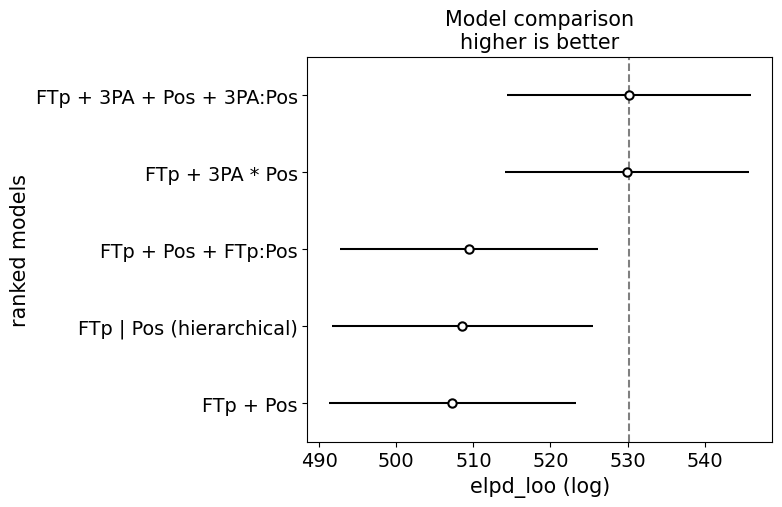

In [20]:
az.plot_compare(cmp_df)

**Task11**:

Which model is "better" according to this metric?

Why do you think that is?

Model 5 was better according to this metric.This is loikely because it has all the variables and the interactions between them meaning all variables were helpful or nonredundant

**Task12:**

The body data set has a measure of body fat percentage (siri), as well as several other measurments of other parts of a person's body, plus their age.

Create a sensible causal diagram for this set of variables.

Based on your causal diagram, which variable should you try to predict? Why?

In [22]:
body = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/body_fat.csv')

In [23]:
body.head()

,siri,age,weight,height,abdomen,thigh,wrist
0,12.3,23,70.1,172,85.2,59.0,17.1
1,6.1,22,78.8,184,83.0,58.7,18.2
2,25.3,22,70.0,168,87.9,59.6,16.6
3,10.4,26,84.0,184,86.4,60.1,18.2
4,28.7,24,83.8,181,100.0,63.2,17.7


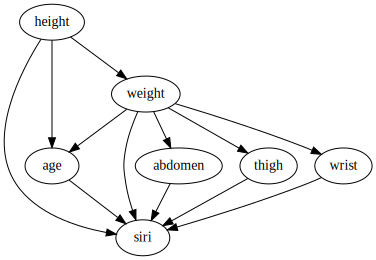

In [27]:
dag_bballh = gv.Digraph(comment='bballh_dag') #bball hierarchy

dag_bballh.node('G', 'siri')
dag_bballh.node('T','age')
dag_bballh.node('P','weight')
dag_bballh.node('X', 'height')
dag_bballh.node('R','abdomen')
dag_bballh.node('V','thigh')
dag_bballh.node('W','wrist')

dag_bballh.edges(['TG','PG','XG','XP','RG','VG', 'WG','PT','XT', 'PR', 'PV', 'PW'])

dag_bballh

We should predict siri because everything sort of is a predictor for siri and could be related.